In [73]:
import numpy as np
import pandas as pd
import seaborn as sns

In [74]:
import rpy2.robjects as robjects

folder_name = '3_state_model'

data_log = pd.read_csv(folder_name + "/close_data_log.csv")

# Helper function to convert R data.frame to pandas DataFrame
def r_to_df(r_df):
    return pd.DataFrame({name: np.array(r_df.rx2(name)) for name in r_df.names})

# Read the RDS files using rpy2
readRDS = robjects.r['readRDS']

hmm_stats_r = readRDS(folder_name + "/hmm_stats_df.rds")
hmm_stats_df = r_to_df(hmm_stats_r)

hmm_state_losses = np.array(readRDS(folder_name + "/hmm_state_losses.rds"))
hmm_predictions = np.array(readRDS(folder_name + "/hmm_predictions.rds"))
hmm_ground_truth = np.array(readRDS(folder_name + "/hmm_ground_truth.rds"))

X_train = np.array(readRDS(folder_name + "/lstm_X_train.rds"))
Y_train = np.array(readRDS(folder_name + "/lstm_Y_train.rds"))
X_valid = np.array(readRDS(folder_name + "/lstm_X_valid.rds"))
Y_valid = np.array(readRDS(folder_name + "/lstm_Y_valid.rds"))
X_test = np.array(readRDS(folder_name + "/lstm_X_test.rds"))
Y_test = np.array(readRDS(folder_name + "/lstm_Y_test.rds"))

n_states = Y_train.shape[2]

In [75]:
hmm_stats_df.set_index('Horizon', inplace=True)
hmm_stats_df

,mean,median,P25,P75,max,min
Horizon,,,,,,
1,0.661648,0.592684,0.331951,0.809167,5.977999,0.024155
2,0.734227,0.654147,0.405796,0.837071,6.001657,0.057787
3,0.784618,0.682004,0.483681,0.866304,6.229743,0.090616
4,0.819369,0.702189,0.545500,0.857691,5.805130,0.134854
5,0.844700,0.712427,0.590729,0.841278,5.461919,0.431225
6,0.858216,0.711020,0.608595,0.825971,5.181384,0.471365
7,0.864442,0.707231,0.625270,0.801057,4.957558,0.503451
8,0.861552,0.708594,0.644182,0.780767,4.776447,0.530941
9,0.852601,0.712063,0.652466,0.776103,4.608543,0.554932


In [76]:
X_train.shape

(577, 5, 20)

In [77]:
print(hmm_predictions.shape)
print(hmm_ground_truth.shape)
print(Y_test.shape)
print(X_train.shape)

(300, 10, 3)
(300, 10, 3)
(300, 10, 3)
(577, 5, 20)


In [78]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.metrics import CategoricalAccuracy, CategoricalCrossentropy
from tensorflow.keras import regularizers

lookback = 10
forecast_horizon = 0

import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.LSTM(16),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.3),
    # Output raw evidence (non-negative)
    layers.Dense(n_states, activation='softplus')  # softplus ≈ log(1+exp(x)) ensures >0; exponential also works but can explode
])

# Compute Dirichlet parameters and predicted probabilities inside the model for convenience
def dirichlet_layer(evidence):
    alpha = evidence + 1
    S = tf.reduce_sum(alpha, axis=-1, keepdims=True)
    probs = alpha / S
    return probs, alpha, S

# Wrapper for Keras with annealing integrated via a tracked epoch variable
class EvidentialLoss(tf.keras.losses.Loss):
    def __init__(self, annealing_rate=100.0, name='evidential_loss'):
        super().__init__(name=name)
        self.annealing_rate = tf.constant(annealing_rate, dtype=tf.float32)
        self.current_epoch = tf.Variable(0.0, trainable=False, dtype=tf.float32)
    
    def call(self, y_true, evidence):
        alpha = evidence + 1
        S = tf.reduce_sum(alpha, axis=-1, keepdims=True)
        probs = alpha / S
        err = tf.square(y_true - probs)
        var = probs * (1 - probs) / (S + 1)
        
        # Annealing factor for the regularization term
        lambda_ = tf.minimum(1.0, self.current_epoch / self.annealing_rate)
        
        return tf.reduce_mean(tf.reduce_sum(err + lambda_ * var, axis=-1))

# Custom callback to update the current epoch in the loss instance
class AnnealingCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if hasattr(self.model, 'loss') and isinstance(self.model.loss, EvidentialLoss):
            self.model.loss.current_epoch.assign(tf.cast(epoch, tf.float32))

model.compile(
    loss=EvidentialLoss(annealing_rate=100.0),
    optimizer=Adam(learning_rate=0.007),
    metrics=['accuracy']  # accuracy computed on argmax(probs)
)

history = model.fit(
    X_train, 
    Y_train[:, forecast_horizon, :], 
    epochs=25, 
    validation_data=(X_valid, Y_valid[:, forecast_horizon, :]), 
    callbacks=[AnnealingCallback()],
    verbose=0)


In [79]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

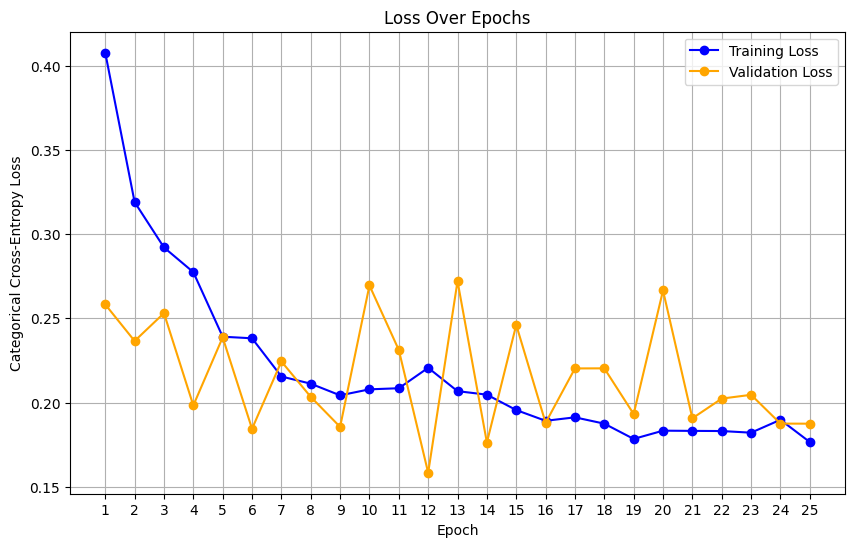

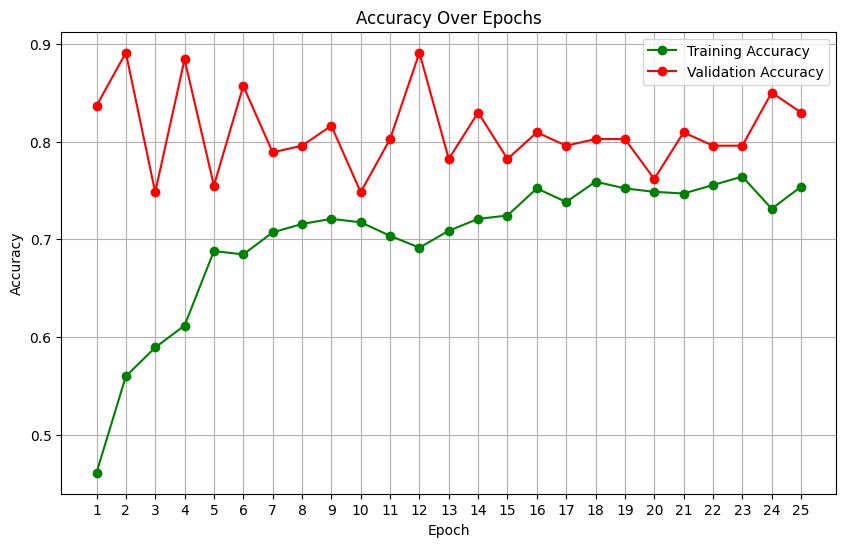

In [80]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history.history['loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['loss'], label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss', marker='o', color='orange')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Categorical Cross-Entropy Loss')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.show()
    
    # Plot Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy', marker='o', color='green')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy', marker='o', color='red')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.xticks(epochs)
    plt.show()

# Call the function after training
plot_training_history(history)

/tmp/ipykernel_2788269/1439376209.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


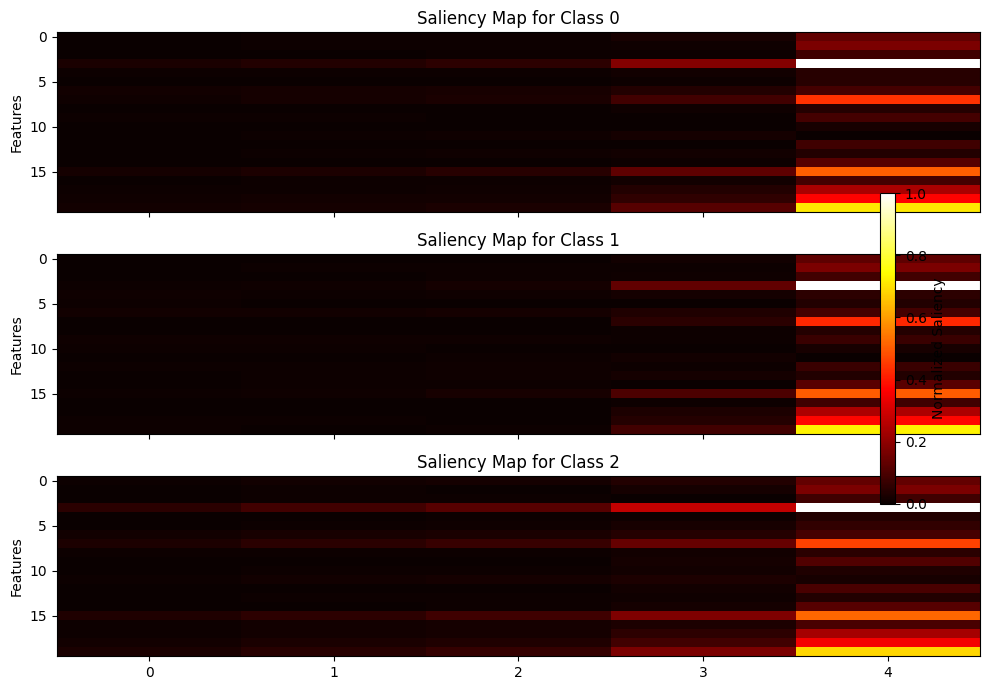

In [81]:
# Saliency Map Computation and Plotting
# Assuming the model is trained and 'data' provides feature_names
feature_names = data_log.columns.tolist()  # List of feature names

# Select a sample input (e.g., the first from validation set)
sample_input = X_valid[2:3]  # Shape: (1, timesteps, features)

# Initialize a list to store saliency maps for each class
saliency_maps = []

for target_class in range(n_states):  # For classes 0, 1, 2
    with tf.GradientTape() as tape:
        # Ensure input is a Tensor and watched by the tape
        input_tensor = tf.convert_to_tensor(sample_input, dtype=tf.float32)
        tape.watch(input_tensor)
        
        # Get model predictions
        predictions = model(input_tensor)
        
        # Select the output for the target class
        class_output = predictions[:, target_class]

    # Compute gradients w.r.t. input
    gradients = tape.gradient(class_output, input_tensor)
    
    # Take absolute values for saliency (importance)
    saliency_map = tf.abs(gradients).numpy()[0]  # Shape: (timesteps, features)
    
    # Transpose for features on y-axis
    saliency_map_transposed = saliency_map.T  # Shape: (features, timesteps)
    
    # Normalize for visualization
    saliency_map_transposed = (saliency_map_transposed - saliency_map_transposed.min()) / \
                              (saliency_map_transposed.max() - saliency_map_transposed.min() + 1e-8)
    
    saliency_maps.append(saliency_map_transposed)

# Plot all three saliency maps stacked vertically
fig, axs = plt.subplots(n_states, 1, figsize=(10, 7), sharex=True)  # 3 rows, 1 column

for i, ax in enumerate(axs):
    im = ax.imshow(saliency_maps[i], cmap='hot', aspect='auto')
    ax.set_title(f'Saliency Map for Class {i}')
    ax.set_ylabel('Features')
    # ax.set_yticks(range(len(feature_names)))
    # ax.set_yticklabels(feature_names)
    

# Add a shared colorbar
fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, pad=0.04, label='Normalized Saliency')

plt.tight_layout()
plt.show()

Compute LSTM loss for 10 step forecast horizon

In [82]:
max_horizon = 10

lstm_state_losses = np.full((len(Y_test), max_horizon), np.nan)
lstm_predictions = np.full((len(Y_test), max_horizon, n_states), np.nan)
lstm_ground_truth = np.full((len(Y_test), max_horizon, n_states), np.nan)
lstm_uncertainty = np.full((len(Y_test), max_horizon), np.nan)
last_state = np.full((len(Y_test), max_horizon, n_states), np.nan)

for forecast_horizon in range(0, max_horizon):
    lookback = 10

    history = model.fit(X_train, Y_train[:, forecast_horizon, :], epochs=25, callbacks=[AnnealingCallback()], verbose=0)
    Y_true = Y_test[:, forecast_horizon, :]

    Y_hat = model.predict(X_test)
    probs, alpha, S = dirichlet_layer(Y_hat)
    
    eps = 1e-15
    loss = -np.sum(Y_true * np.log(np.clip(probs, eps, 1.0)), axis=1)
    lstm_state_losses[0:len(loss), forecast_horizon] = loss
    lstm_predictions[0:len(loss), forecast_horizon, :] = probs
    lstm_ground_truth[0:len(loss), forecast_horizon, :] = Y_true
    last_state[0:len(loss), forecast_horizon, :] = X_test[:, -1, :n_states]
    lstm_uncertainty[0:len(loss), forecast_horizon] = S[:, 0]



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [83]:
# Compute statistics for each column of lstm_state_losses
stats = {
    'mean': np.nanmean(lstm_state_losses, axis=0),
    'median': np.nanmedian(lstm_state_losses, axis=0),
    'P25': np.nanpercentile(lstm_state_losses, 25, axis=0),
    'P75': np.nanpercentile(lstm_state_losses, 75, axis=0),
    'max': np.nanmax(lstm_state_losses, axis=0),
    'min': np.nanmin(lstm_state_losses, axis=0)
}

# Convert to DataFrame for better display
lstm_stats_df = pd.DataFrame(stats, index=[i+1 for i in range(lstm_state_losses.shape[1])])
lstm_stats_df

,mean,median,P25,P75,max,min
1,0.804668,0.622556,0.431044,1.013470,3.582314,0.061546
2,1.007062,0.723190,0.490802,1.286475,3.978005,0.062015
3,1.008164,0.863252,0.525713,1.232881,4.123382,0.096007
4,1.235769,0.908486,0.502315,1.611566,4.313429,0.100431
5,1.281154,1.033404,0.532769,1.764828,4.287109,0.085565
6,1.208326,0.908101,0.499551,1.749799,4.862718,0.142621
7,1.203353,0.940998,0.489072,1.797559,5.353212,0.150259
8,1.115866,0.764666,0.505847,1.458069,5.607395,0.150224
9,1.076042,0.746527,0.558689,1.173073,5.767355,0.175147
10,1.199359,0.936216,0.514786,1.646241,5.694594,0.133509


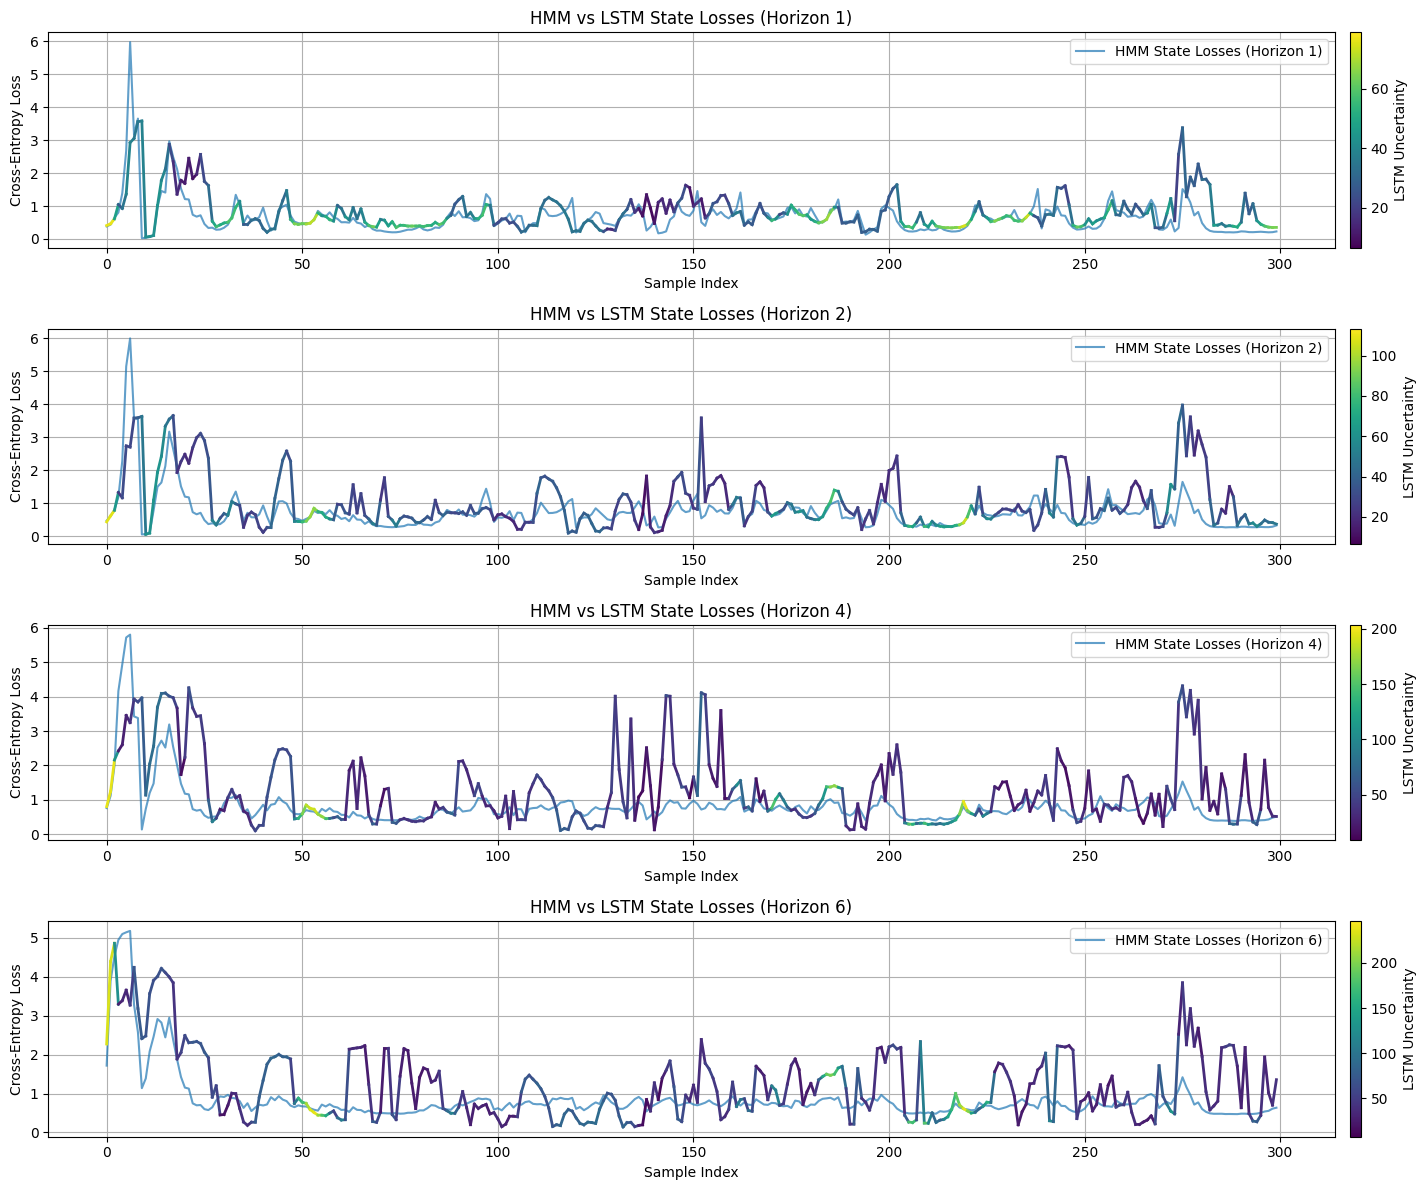

In [84]:
plt.figure(figsize=(16, 12))

# Horizon indices (0-based): 0, 1, 3
horizons = [0, 1, 3, 5]
titles = ['Horizon 1', 'Horizon 2', 'Horizon 4', 'Horizon 6']

for i, (h, title) in enumerate(zip(horizons, titles), 1):
    plt.subplot(len(horizons), 1, i)
    plt.plot(hmm_state_losses[:, h], label=f'HMM State Losses ({title})', alpha=0.7)
    
    # Color the LSTM line by uncertainty using a colormap
    lstm_loss = lstm_state_losses[:, h]
    lstm_unc = lstm_uncertainty[:, h]
    norm = plt.Normalize(lstm_unc.min(), lstm_unc.max())
    cmap = plt.get_cmap('viridis')
    for j in range(len(lstm_loss) - 1):
        plt.plot([j, j+1], [lstm_loss[j], lstm_loss[j+1]],
                 color=cmap(norm((lstm_unc[j] + lstm_unc[j+1]) / 2)), linewidth=2)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.01)
    cbar.set_label('LSTM Uncertainty')
    
    plt.xlabel('Sample Index')
    plt.ylabel('Cross-Entropy Loss')
    plt.title(f'HMM vs LSTM State Losses ({title})')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

plt.show()

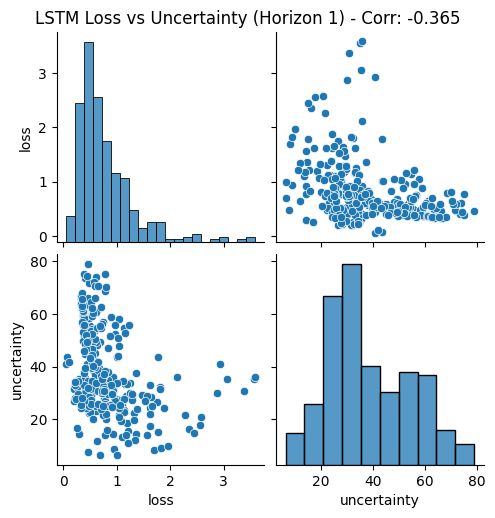

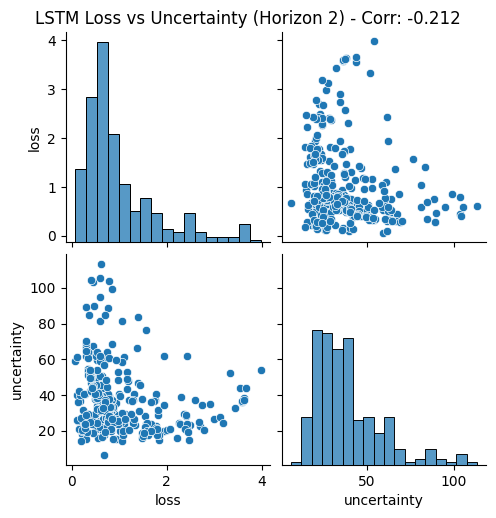

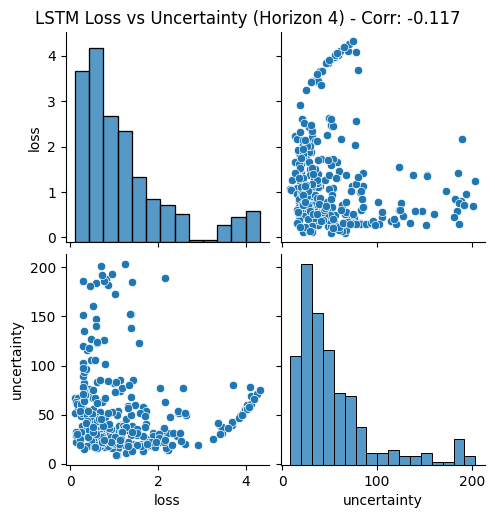

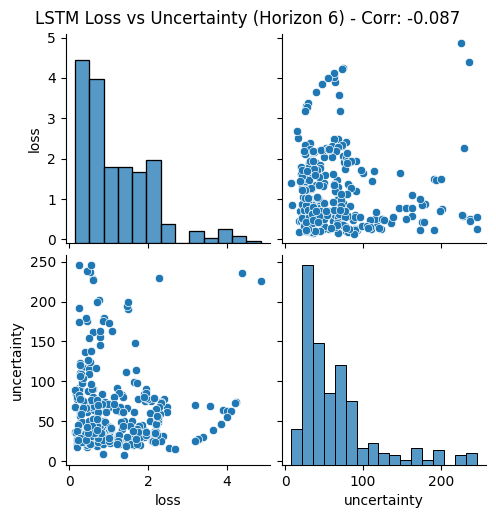

In [85]:
for i, (h, title) in enumerate(zip(horizons, titles), 1):
    corr = np.corrcoef(lstm_state_losses[:, h], lstm_uncertainty[:, h])[0, 1]
    g = sns.pairplot(
        pd.DataFrame({'loss': lstm_state_losses[:, h], 'uncertainty': lstm_uncertainty[:, h]})
    )
    g.figure.suptitle(f'LSTM Loss vs Uncertainty ({title}) - Corr: {corr:.3f}', y=1.02)


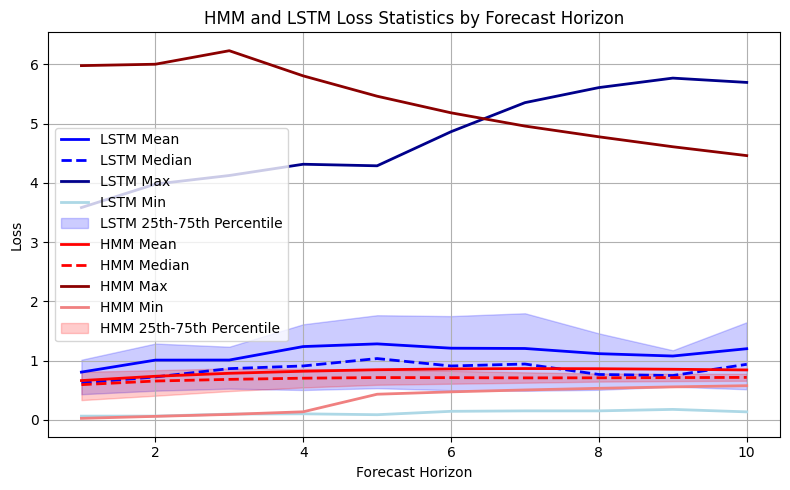

In [86]:
fig, ax = plt.subplots(figsize=(8, 5))

horizons = lstm_stats_df.index

# Plot LSTM stats
ax.plot(horizons, lstm_stats_df['mean'], label='LSTM Mean', color='blue', linewidth=2)
ax.plot(horizons, lstm_stats_df['median'], label='LSTM Median', color='blue', linestyle='--', linewidth=2)
ax.plot(horizons, lstm_stats_df['max'], label='LSTM Max', color='darkblue', linewidth=2)
ax.plot(horizons, lstm_stats_df['min'], label='LSTM Min', color='lightblue', linewidth=2)
ax.fill_between(horizons, lstm_stats_df['P25'], lstm_stats_df['P75'], color='blue', alpha=0.2, label='LSTM 25th-75th Percentile')

# plot HMM stats
horizons = hmm_stats_df.index
ax.plot(horizons, hmm_stats_df['mean'], label='HMM Mean', color='red', linewidth=2)
ax.plot(horizons, hmm_stats_df['median'], label='HMM Median', color='red', linestyle='--', linewidth=2)
ax.plot(horizons, hmm_stats_df['max'], label='HMM Max', color='darkred', linewidth=2)
ax.plot(horizons, hmm_stats_df['min'], label='HMM Min', color='lightcoral', linewidth=2)
ax.fill_between(horizons, hmm_stats_df['P25'], hmm_stats_df['P75'], color='red', alpha=0.2, label='HMM 25th-75th Percentile')

ax.set_xlabel('Forecast Horizon')
ax.set_ylabel('Loss')
ax.set_title('HMM and LSTM Loss Statistics by Forecast Horizon')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [87]:
lstm_loss_comparison = pd.DataFrame(hmm_state_losses - lstm_state_losses)
lstm_loss_comparison.describe()

,0,1,2,3,4,5,6,7,8,9
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000
mean,-0.143020,-0.272835,-0.223546,-0.416400,-0.436455,-0.350110,-0.338912,-0.254314,-0.223441,-0.358269
std,0.498103,0.716853,0.640018,0.908083,0.837079,0.737355,0.722760,0.658816,0.587193,0.700251
min,-3.558160,-3.577721,-3.924054,-3.828010,-3.453153,-2.426355,-3.279539,-3.007129,-3.231242,-2.305942
25%,-0.231029,-0.440120,-0.473514,-0.752274,-0.927274,-0.930001,-0.891502,-0.660358,-0.381117,-0.867841
50%,-0.056226,-0.085289,-0.114444,-0.143469,-0.258896,-0.166679,-0.183215,-0.026711,-0.016103,-0.159238
75%,0.054797,0.044565,0.047168,0.103989,0.158574,0.192550,0.216408,0.156737,0.077356,0.177085
max,3.053135,3.294458,3.085706,2.560300,2.227867,1.906560,1.491795,0.943961,1.124998,0.886346


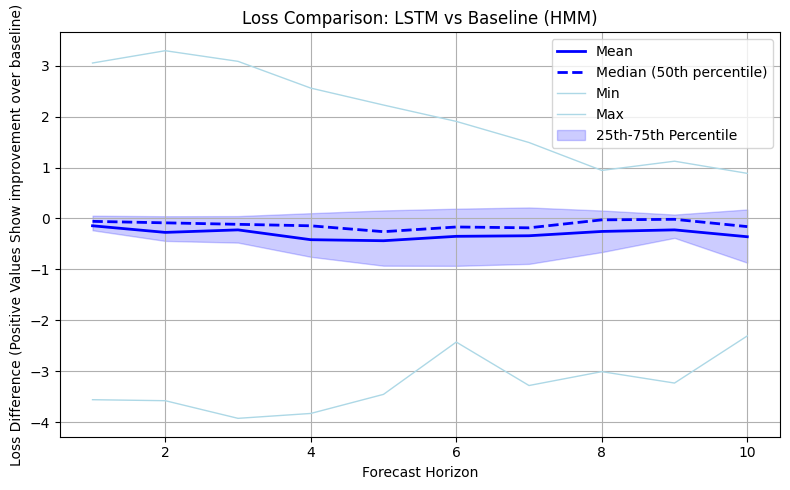

In [88]:
def plot_loss_comparison(loss_comparison):
    fig, ax = plt.subplots(figsize=(8, 5))

    horizons = np.arange(1, loss_comparison.shape[1] + 1)

    # Compute statistics
    mean = loss_comparison.mean(axis=0)
    median = loss_comparison.median(axis=0)
    p25 = loss_comparison.quantile(0.25, axis=0)
    p75 = loss_comparison.quantile(0.75, axis=0)
    min_ = loss_comparison.min(axis=0)
    max_ = loss_comparison.max(axis=0)

    # Plot mean (solid)
    ax.plot(horizons, mean, label='Mean', color='blue', linewidth=2)
    # Plot median (dashed)
    ax.plot(horizons, median, label='Median (50th percentile)', color='blue', linestyle='--', linewidth=2)
    # Plot min/max (light solid)
    ax.plot(horizons, min_, label='Min', color='lightblue', linewidth=1)
    ax.plot(horizons, max_, label='Max', color='lightblue', linewidth=1)
    # Fill between 25th and 75th percentile
    ax.fill_between(horizons, p25, p75, color='blue', alpha=0.2, label='25th-75th Percentile')

    ax.set_xlabel('Forecast Horizon')
    ax.set_ylabel('Loss Difference (Positive Values Show improvement over baseline)')
    ax.set_title('Loss Comparison: LSTM vs Baseline (HMM)')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()
plot_loss_comparison(lstm_loss_comparison)

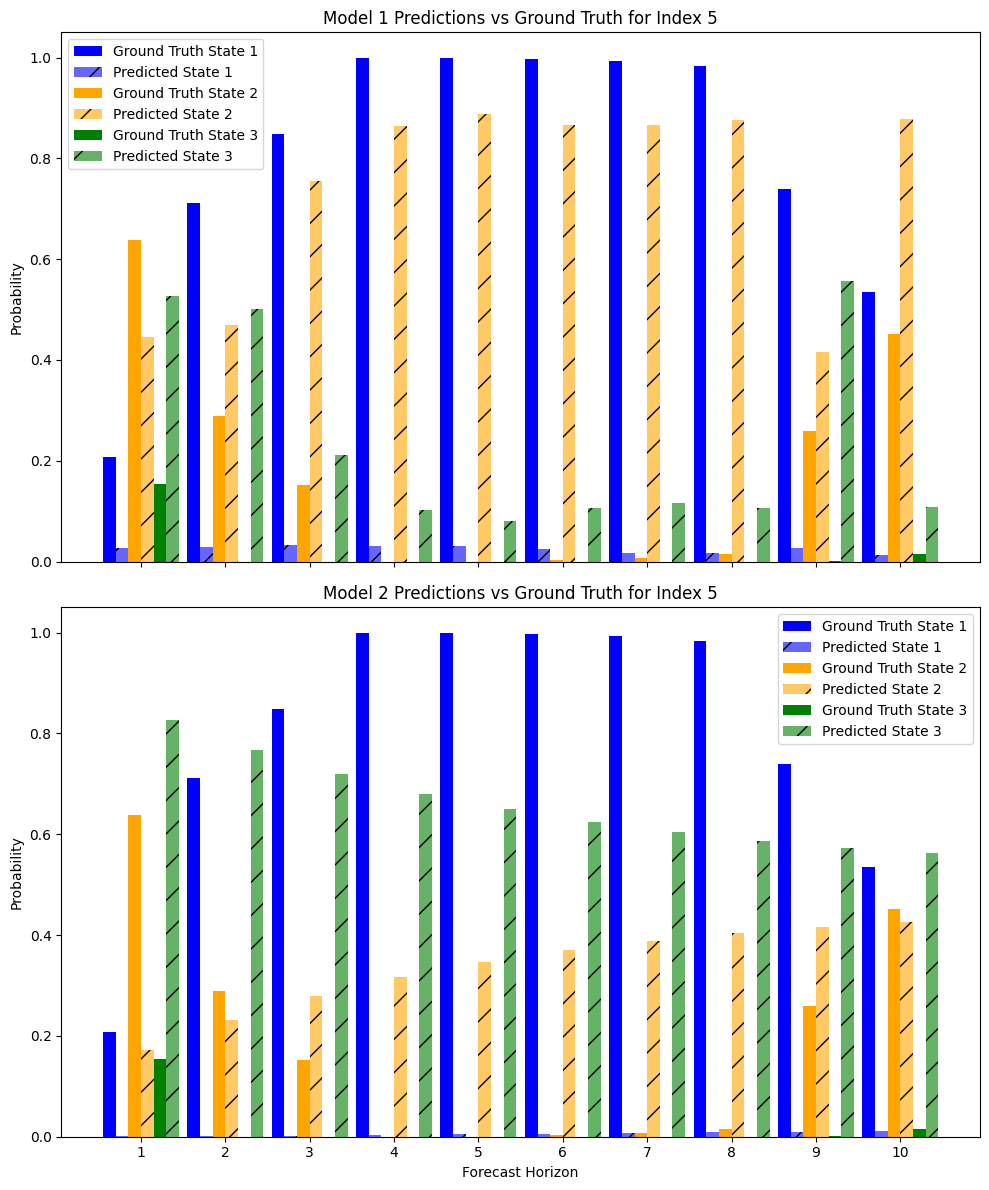

In [89]:
import numpy as np
import matplotlib.pyplot as plt

def plot_comparison_bars(model_1_predictions, model_2_predictions, ground_truth, index):
    # Assuming lstm_predictions, lstm_ground_truth, hmm_predictions, and hmm_ground_truth are defined as 3D arrays (e.g., shape: samples, horizons, states)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
    forecast_range = np.arange(model_1_predictions.shape[1])
    bar_width = 0.15
    # Plot for Model 1 on ax1
    for state, color in zip(range(n_states), ['blue', 'orange', 'green']):
        offset = state * (bar_width * 2)
        # Plot ground truth (solid, opaque)
        ax1.bar(
            forecast_range + offset,
            ground_truth[index, :, state],
            width=bar_width,
            label=f'Ground Truth State {state+1}',
            color=color,
            alpha=1
        )
        # Plot predictions (with striped pattern for distinction)
        ax1.bar(
            forecast_range + offset + bar_width,
            model_1_predictions[index, :, state],
            width=bar_width,
            label=f'Predicted State {state+1}',
            color=color,
            alpha=0.6,
            hatch='/'
        )

    # Avoid duplicate labels in legend for ax1
    handles1, labels1 = ax1.get_legend_handles_labels()
    unique1 = dict(zip(labels1, handles1))
    ax1.legend(unique1.values(), unique1.keys())
    ax1.set_ylabel('Probability')
    ax1.set_title(f'Model 1 Predictions vs Ground Truth for Index {index}')

    # Plot for Model 2 on ax2
    for state, color in zip(range(n_states), ['blue', 'orange', 'green']):
        offset = state * (bar_width * 2)
        # Plot ground truth (solid, opaque)
        ax2.bar(
            forecast_range + offset,
            ground_truth[index, :, state],
            width=bar_width,
            label=f'Ground Truth State {state+1}',
            color=color,
            alpha=1
        )
        # Plot predictions (with striped pattern for distinction)
        ax2.bar(
            forecast_range + offset + bar_width,
            model_2_predictions[index, :, state],
            width=bar_width,
            label=f'Predicted State {state+1}',
            color=color,
            alpha=0.6,
            hatch='/'
        )

    # Avoid duplicate labels in legend for ax2
    handles2, labels2 = ax2.get_legend_handles_labels()
    unique2 = dict(zip(labels2, handles2))
    ax2.legend(unique2.values(), unique2.keys())
    ax2.set_xlabel('Forecast Horizon')
    ax2.set_ylabel('Probability')
    ax2.set_title(f'Model 2 Predictions vs Ground Truth for Index {index}')

    # Set x-ticks centered for each group
    xtick_positions = forecast_range + bar_width * 2.5
    ax2.set_xticks(xtick_positions)
    ax2.set_xticklabels([str(i+1) for i in forecast_range])

    plt.tight_layout()
    plt.show()

plot_comparison_bars(lstm_predictions, hmm_predictions, lstm_ground_truth, index=5)

## Testing combined transition probability model

In [ ]:
# Transition matrix from the HMM
transition_matrix = np.array([[0.974, 0.026, 0.000],
                              [0.004, 0.951, 0.045],
                              [0.000, 0.051, 0.949]])
# transition_matrix = np.array([[0.927, 0.073],
#                               [0.042, 0.958]])

#         state 1 state 2 state 3
# state 1   0.976   0.024   0.000
# state 2   0.004   0.894   0.102
# state 3   0.000   0.093   0.907


transition_matrix = np.array([[0.960, 0.024, 0.016],
                              [0.289, 0.711, 0.000],
                              [0.034, 0.006, 0.960]])

alpha = 1
trials = lstm_predictions.shape[0]
horizons = lstm_predictions.shape[1]
combined_transitions = np.zeros((trials, horizons, n_states, n_states))
for trial in range(trials):
    for horizon in range(horizons):
        #_alpha = (alpha + 0) / (horizon + 0 + 1)
        combined = np.tile(lstm_predictions[trial, horizon, :], (n_states, 1)) * alpha + transition_matrix * (1 - alpha)
        combined_transitions[trial, horizon, :, :] = combined

combined_predictions = np.zeros((trials, horizons, n_states))
for trial in range(trials):
    for horizon in range(horizons):
        if horizon == 0:
            last_prediction = last_state[trial, 0, :]
        else:
            last_prediction = combined_predictions[trial, horizon - 1, :]
        next_prediction = last_prediction @ combined_transitions[trial, horizon, :, :]
        combined_predictions[trial, horizon, :] = next_prediction

In [93]:
# Compute cross-entropy loss per trial and per horizon between combined_predictions and lstm_ground_truth
eps = 1e-15  # for numerical stability
combined_state_loss = -np.sum(
    lstm_ground_truth * np.log(np.clip(combined_predictions, eps, 1.0)),
    axis=2
)  # shape: (trials, horizons)

combined_state_loss.shape

(300, 10)

In [95]:
# Compute statistics for each column of state_losses
combined_stats = {
    'mean': np.nanmean(combined_state_loss, axis=0),
    'median': np.nanmedian(combined_state_loss, axis=0),
    'P25': np.nanpercentile(combined_state_loss, 25, axis=0),
    'P75': np.nanpercentile(combined_state_loss, 75, axis=0),
    'max': np.nanmax(combined_state_loss, axis=0),
    'min': np.nanmin(combined_state_loss, axis=0)
}

# Convert to DataFrame for better display
combined_stats_df = pd.DataFrame(combined_stats, index=[i+1 for i in range(combined_state_loss.shape[1])])
combined_stats_df

,mean,median,P25,P75,max,min
1,0.804668,0.622556,0.431044,1.013470,3.582315,0.061546
2,1.007062,0.723190,0.490802,1.286475,3.978004,0.062015
3,1.008164,0.863252,0.525713,1.232881,4.123382,0.096007
4,1.235769,0.908486,0.502315,1.611566,4.313429,0.100431
5,1.281154,1.033404,0.532769,1.764828,4.287109,0.085565
6,1.208326,0.908101,0.499551,1.749799,4.862718,0.142621
7,1.203353,0.940998,0.489072,1.797559,5.353212,0.150259
8,1.115866,0.764666,0.505847,1.458069,5.607395,0.150224
9,1.076042,0.746527,0.558689,1.173072,5.767355,0.175147
10,1.199359,0.936216,0.514786,1.646241,5.694594,0.133509


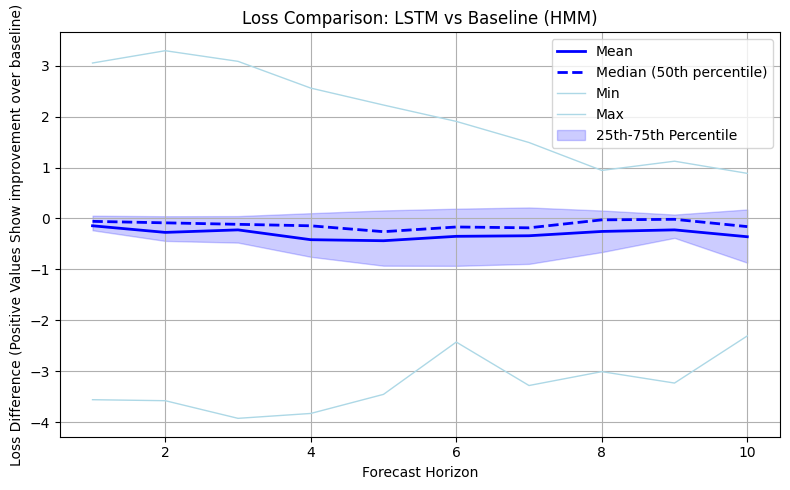

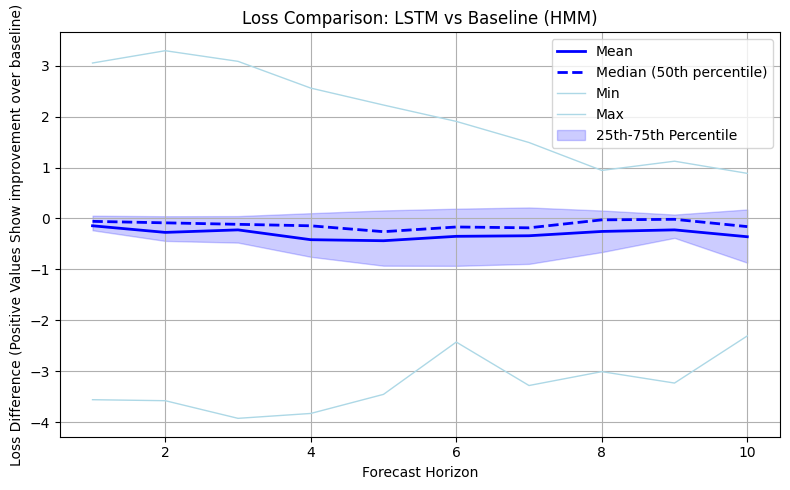

In [97]:
plot_loss_comparison(lstm_loss_comparison)
plot_loss_comparison(pd.DataFrame(hmm_state_losses - combined_state_loss))

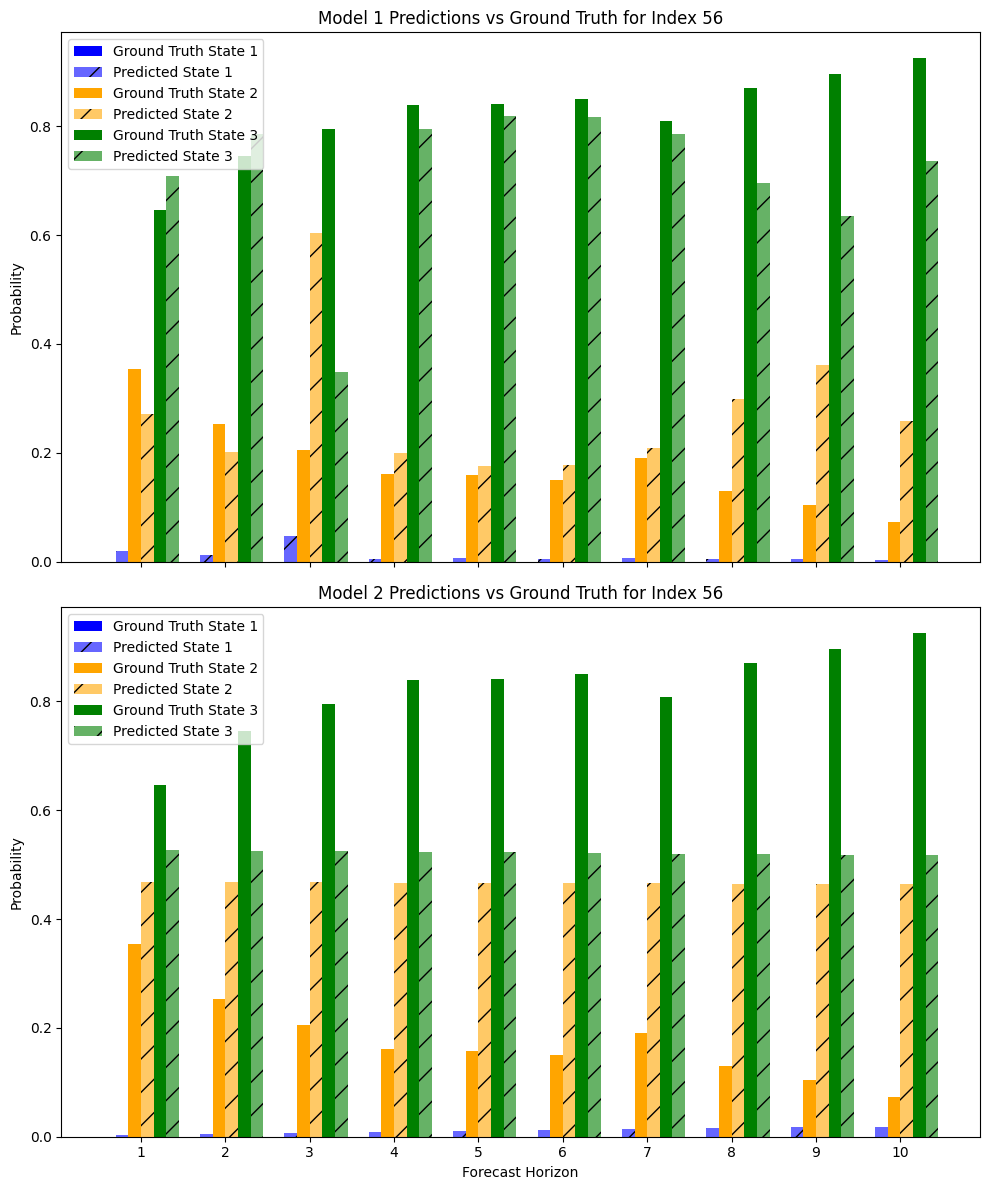

In [98]:
plot_comparison_bars(combined_predictions, hmm_predictions, hmm_ground_truth, index=56)

## Test using dropout layers to determine the model's predictive uncertainty.



In [99]:
# Define the mc_dropout_predictions function
def mc_dropout_predictions(model, X, Y_true=None, num_samples=1000):
    predictions = np.stack([model(X, training=True) for _ in range(num_samples)], axis=0)
    probs, alpha, S = dirichlet_layer(predictions)
    num_examples, num_classes = probs.shape[1], probs.shape[2]
    mean_probs = np.mean(probs, axis=0)
    mean_S = np.mean(S, axis=0)
    std_S = np.std(S, axis=0)
    epsilon = 1e-10
    entropy = -np.sum(mean_probs * np.log(mean_probs + epsilon), axis=1, keepdims=True)
    std_dev = np.std(probs, axis=0)
    mean_std_dev = np.mean(std_dev, axis=1, keepdims=True)
    max_std_dev = np.max(std_dev, axis=1, keepdims=True)
    per_sample_loss = np.zeros((num_examples, 1))
    if Y_true is not None:
        Y_true = np.asarray(Y_true)
        cross_entropy = -np.sum(Y_true * np.log(mean_probs + epsilon), axis=1, keepdims=True)
        per_sample_loss = cross_entropy
    df = pd.DataFrame()
    df[[f'Class_{i}_True' for i in range(num_classes)]] = Y_true
    df[[f'Class_{i}_Prob' for i in range(num_classes)]] = mean_probs
    df['Predictive_Entropy'] = entropy
    for i in range(num_classes):
        df[f'Class_{i}_StdDev'] = std_dev[:, i]
    df['Mean_StdDev'] = mean_std_dev
    df['Max_StdDev'] = max_std_dev
    df['Per_Sample_Loss'] = per_sample_loss
    df['Per_sample_uncertainty_mean'] = mean_S
    df['Per_sample_uncertainty_std'] = std_S

    return df

In [131]:
lookback = 10
forecast_horizon = 5

model.fit(X_train, Y_train[:, forecast_horizon, :], epochs=50, verbose=0)

uncertainty_df = mc_dropout_predictions(model, X_test, Y_test[:, forecast_horizon, :], num_samples=100)

In [132]:
uncertainty_df['hmm_loss'] = hmm_state_losses[:, forecast_horizon]
uncertainty_df['loss_difference'] = uncertainty_df['hmm_loss'] - uncertainty_df['Per_Sample_Loss']
uncertainty_df.head()

,Class_0_True,Class_1_True,Class_2_True,Class_0_Prob,Class_1_Prob,Class_2_Prob,Predictive_Entropy,Class_0_StdDev,Class_1_StdDev,Class_2_StdDev,Mean_StdDev,Max_StdDev,Per_Sample_Loss,Per_sample_uncertainty_mean,Per_sample_uncertainty_std,hmm_loss,loss_difference
0,0.207079,6.385189e-01,1.544018e-01,0.003735,0.396657,0.599607,0.694350,0.001451,0.089418,0.089710,0.060193,0.089710,1.826949,298.373077,89.739227,1.718290,-0.10866
1,0.711569,2.884306e-01,9.327782e-09,0.003910,0.217901,0.778189,0.548856,0.002493,0.047926,0.049433,0.033284,0.049433,4.384585,314.997925,115.785950,3.894436,-0.49015
2,0.847860,1.521397e-01,1.004233e-10,0.003362,0.142645,0.853993,0.431721,0.002533,0.043336,0.043414,0.029761,0.043414,5.125058,371.331238,143.417816,4.535898,-0.58916
3,1.000000,8.120170e-14,1.199071e-78,0.024538,0.888354,0.087108,0.408740,0.061373,0.060641,0.008890,0.043635,0.061373,3.707513,75.028030,31.278107,4.949813,1.24230
4,1.000000,1.434622e-11,4.216934e-63,0.014309,0.690490,0.295201,0.676670,0.006783,0.105111,0.102881,0.071592,0.105111,4.246838,82.139931,30.034096,5.100038,0.85320


Correlation matrix:
                              loss_difference  Per_Sample_Loss  Mean_StdDev  \
loss_difference                     1.000000        -0.716997    -0.001213   
Per_Sample_Loss                    -0.716997         1.000000    -0.014577   
Mean_StdDev                        -0.001213        -0.014577     1.000000   
Max_StdDev                          0.003884        -0.017705     0.995103   
Predictive_Entropy                  0.250830        -0.325066     0.701939   
Per_sample_uncertainty_mean         0.240692        -0.222903    -0.315562   
Per_sample_uncertainty_std          0.208549        -0.187327    -0.400665   

                             Max_StdDev  Predictive_Entropy  \
loss_difference                0.003884            0.250830   
Per_Sample_Loss               -0.017705           -0.325066   
Mean_StdDev                    0.995103            0.701939   
Max_StdDev                     1.000000            0.721022   
Predictive_Entropy             0.721022

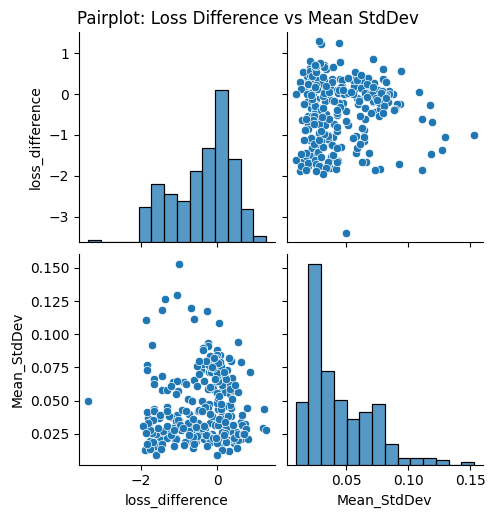

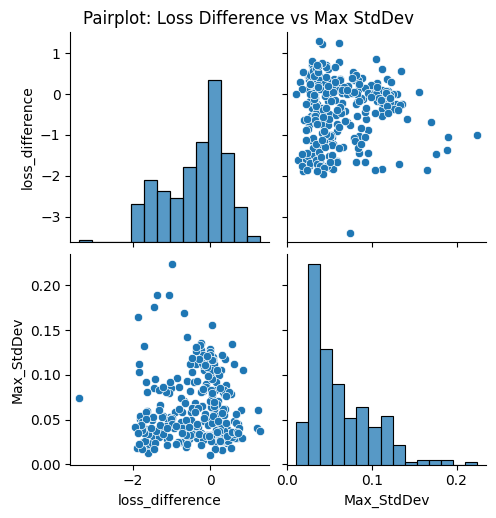

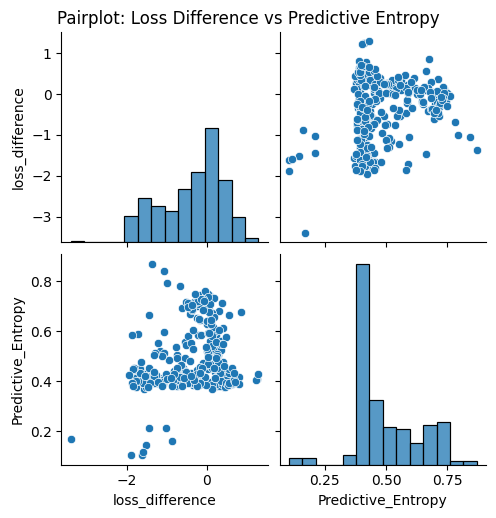

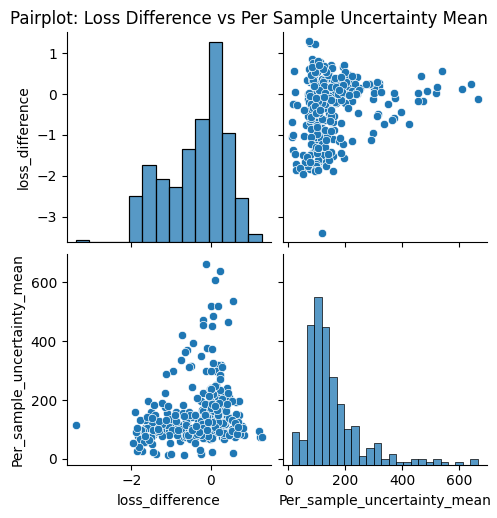

In [133]:
import seaborn as sns

import matplotlib.pyplot as plt

# Check correlation between Per_Sample_Loss, Mean_StdDev, and Max_StdDev
corr = uncertainty_df[['loss_difference', 'Per_Sample_Loss', 'Mean_StdDev', 'Max_StdDev', 'Predictive_Entropy', 'Per_sample_uncertainty_mean', 'Per_sample_uncertainty_std']].corr()
print("Correlation matrix:\n", corr)

# Pairplot for visual inspection
sns.pairplot(uncertainty_df[['loss_difference', 'Mean_StdDev']])
plt.suptitle("Pairplot: Loss Difference vs Mean StdDev", y=1.02)

# Pairplot for visual inspection
sns.pairplot(uncertainty_df[['loss_difference', 'Max_StdDev']])
plt.suptitle("Pairplot: Loss Difference vs Max StdDev", y=1.02)
# Pairplot for visual inspection
sns.pairplot(uncertainty_df[['loss_difference', 'Predictive_Entropy']])
plt.suptitle("Pairplot: Loss Difference vs Predictive Entropy", y=1.02)

sns.pairplot(uncertainty_df[['loss_difference', 'Per_sample_uncertainty_mean']])
plt.suptitle("Pairplot: Loss Difference vs Per Sample Uncertainty Mean", y=1.02)

plt.show()

In [134]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

# Pearson correlation only measures pairwise (linear) relationships.
# For correlation between one variable and a set of variables, use "multiple correlation" (multiple R).
# This is the square root of the R^2 from a multiple linear regression.


X = uncertainty_df[[
    'Predictive_Entropy', 
    'Mean_StdDev', 
    'Per_sample_uncertainty_mean', 
    'Per_sample_uncertainty_std'
]].values
y = uncertainty_df['loss_difference'].values

reg = LinearRegression().fit(X, y)
r_squared = reg.score(X, y)
multiple_correlation = np.sqrt(r_squared)
print(f"Multiple correlation (R) between loss_difference and [Predictive_Entropy, Mean_StdDev, Per_sample_uncertainty_mean, Per_sample_uncertainty_std]: {multiple_correlation:.3f}")

Multiple correlation (R) between loss_difference and [Predictive_Entropy, Mean_StdDev, Per_sample_uncertainty_mean, Per_sample_uncertainty_std]: 0.418


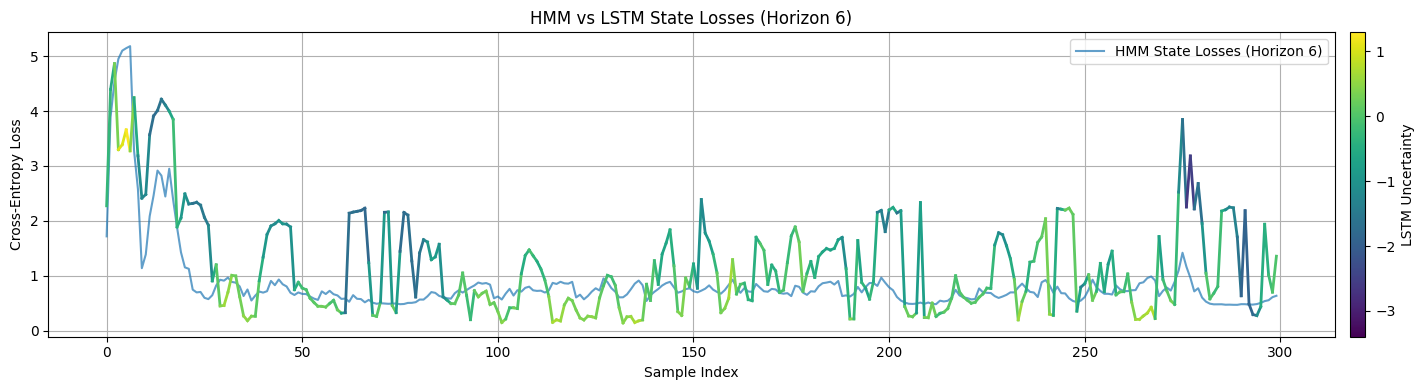

In [135]:
plt.figure(figsize=(16, 4))

plt.plot(hmm_state_losses[:, forecast_horizon], label=f'HMM State Losses ({title})', alpha=0.7)

# Color the LSTM line by uncertainty using a colormap
lstm_loss = lstm_state_losses[:, forecast_horizon]
lstm_unc = y
norm = plt.Normalize(lstm_unc.min(), lstm_unc.max())
cmap = plt.get_cmap('viridis')
for j in range(len(lstm_loss) - 1):
    plt.plot([j, j+1], [lstm_loss[j], lstm_loss[j+1]],
                color=cmap(norm((lstm_unc[j] + lstm_unc[j+1]) / 2)), linewidth=2)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca(), pad=0.01)
cbar.set_label('LSTM Uncertainty')

plt.xlabel('Sample Index')
plt.ylabel('Cross-Entropy Loss')
plt.title(f'HMM vs LSTM State Losses ({title})')
plt.legend()
plt.grid(True)
plt.tight_layout()
